# **BiotrAIn 2025 Tutorial: Beta Diversity Analysis**

## Section 02: Comparing microbial community structures by Unifrac - Beta diversity

🕒 Time: 14:00 - 15:00 EDT | 📅 June 17, 2025

Welcome to the practical session 02.
Created by professor Qiyun Zhu and adapted by Nelly Selem (Secodment host), Jeanett Daga (Secodment).

--- 

🏆 **QUESTIONS**

* How do we quantify and interpret cross-environment microbial community differences?
* Why use phylogeny-aware metrics (UniFrac) over non-phylogenetic measures?
* What statistical and visualization tools best reveal community patterns?

🎯 **AIMS**

* **Process data**: Filter, rarefy, and compute UniFrac distances
* **Analyze patterns**: PCoA visualization + PERMANOVA testing
* **Compare communities**: Phylogenetic tree manipulation, Mantel, and Procrustes tests

🔑 **KEY POINTS** 

1. **UniFrac**
   - **Type**: Phylogenetic beta-diversity metric
   - **Measures**: 
     - ✓ Taxonomic abundance profiles  
     - ✓ Evolutionary relationships (shared branch lengths in phylogenetic tree)
   - **Advantage**: More informative than non-phylogenetic metrics (e.g., Bray-Curtis) as it incorporates evolutionary history

2. **Rarefaction**
   - **Purpose**: Normalizes sequencing depth across samples to:
     - ✓ Control for uneven sampling effort  
     - ✓ Enable fair cross-sample comparisons
   - **Trade-off**: Reduces noise but discards valid data (balance needed)

3. **Principal Coordinates Analysis (PCoA)**
   - **Function**: Dimensionality reduction for distance matrices (e.g., UniFrac)
   - **Interpretation**:
     - Close points = similar microbial communities  
     - Distant points = dissimilar communities
   - **Output**: 2D/3D plots showing major axes of variation

4. **PERMANOVA**
   - **Purpose**: Tests whether community composition differs significantly between pre-defined groups
   - **Key outputs**:
     - *F*-statistic (effect size)  
     - *p*-value (statistical significance)

5. **Phylogenetic Tree Subsetting**
   - **Application**: Focuses analysis on specific clades by:
     - ✓ Extracting subtrees (e.g., single phylum)  
     - ✓ Enabling targeted evolutionary comparisons

6. **Comparative Analyses**

| **Test**       | **Compares**                      | **Application Example**                    |
|----------------|-----------------------------------|--------------------------------------------|
| **Mantel**     | Two distance matrices             | UniFrac vs. environmental parameters       |
| **Procrustes** | Two ordinations (e.g., PCoA)      | Comparing different beta-diversity metrics |

---

📥 **Input**: 

Latino America Shotgun data from EMP500 project:

* `latam_ogu.biom`: Feature table (OGU abundances)
* `latam_ogu.tax`: Taxonomic classifications
* `latam_ogu.nwk`: Reference phylogeny (Newick format)
* `latam_samples.tsv`: Sample metadata

📤 **Output**:

- Rarefied BIOM table
- Weighted/unweighted UniFrac matrices
- PCoA ordination plots + coordinates
- PERMANOVA results (*F*-statistics, *p*-values)
- Phylum-specific distance comparisons
- Mantel (r/p) and Procrustes (M²/p) results

--- 

## Phylogenetic Beta Diversity Analysis

In this session, we will analyze beta diversity patterns in the EMP500 shotgun metagenomics dataset using **phylogenetically-informed methods**:

### UniFrac Analysis

- **Metric**: We will employ UniFrac, a gold-standard phylogenetic beta diversity measure that:
  - Quantifies community dissimilarity based on shared evolutionary history
  - Computes the fraction of unique branch lengths in a phylogenetic tree between sample pairs
- **Variants**: Both weighted (abundance-sensitive) and unweighted (presence/absence) versions will be explored

### Multivariate Analysis Pipeline

1. **Visualization**  
   Principal Coordinates Analysis (PCoA) will transform UniFrac distance matrices into intuitive 2D/3D plots, revealing:
   - Major axes of community variation
   - Potential sample clustering patterns

2. **Statistical Testing**  
   PERMANOVA (Permutational Multivariate ANOVA) will assess whether:
   - Observed community differences between sample groups are statistically significant
   - Effect sizes of experimental factors

### Advanced Comparisons

To demonstrate scikit-bio's capabilities, we will:
- **Mantel Test**: Evaluate matrix correlations between phylum-specific distance matrices  
- **Procrustes Analysis**: Quantify concordance between ordinations of different microbial groups  



## Preparation

Install the latest scikit-bio version and another required packages in your Google Colab environment. 

In [1]:
# Import find_spec from importlib.util
from importlib.util import find_spec

In [2]:
# Install scikit-bio if not already installed
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [4]:
# Import the skbio library and check the version. 
import skbio
print(f"scikit-bio version: {skbio.__version__}")

scikit-bio version: 0.6.3


In [7]:
# Import pyplot of matplotlib 
import matplotlib.pyplot as plt

In [8]:
# Import warnings to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Base URL of GitHub repository containing the data
github_data_path = "https://raw.githubusercontent.com/nselem/biotraintemp/refs/heads/main/data/"

In [10]:
# Assign the GitHub data path to HOME variable
HOME = github_data_path

**Data Loading and Phylogenetic Analysis Setup**

Before conducting any downstream analyses, we must first load our essential datasets into memory. This foundational step enables all subsequent exploration of microbial community patterns.

1. **Phylogeny Initialization**
 
   We begin by parsing the phylogenetic tree into a `TreeNode` object using scikit-bio's implementation. This powerful class provides:
    
   * Tree traversal (pre-order, post-order, level-order)
   * Topological operations (subtree extraction, node comparison)
   * Data aggregation (clade-specific tip collection)
   * Evolutionary metrics (branch length calculations)

2. **Practical Applications**
   
   Later in this notebook, we'll demonstrate two key workflows:

   * Phylogeny-aware aggregation: Propagating tip data upward through the tree hierarchy
   * Targeted clade analysis: Isolating specific taxonomic groups (e.g., Proteobacteria) for focused investigation

In [11]:
# Import TreeNode from skbio
from skbio import TreeNode

In [12]:
# Read the phylogenetic tree from a Newick file
phylogeny = TreeNode.read(f'{HOME}/shotgun/latam_ogu.nwk', format= 'newick')
phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

**Loading Feature Tables with Sparse Optimization**

We will now load the feature table into a `Table` object, which employs efficient sparse matrix storage to handle microbial abundance data. This representation is critical given the extreme sparsity typical in microbiome datasets—for example, the American Gut Project exhibits <0.1% non-zero values in its feature tables.

**Key Features of the Table Object**

* **Sparse storage**: Only non-zero values occupy memory (ideal for 99.9% sparse data)
* **Analytical methods**:
  * *Filtering* (prevalence/abundance thresholds)
  * *Transformation* (log-normalization, CSS scaling)
  * *Aggregation* (taxonomic collapsing)
  * *Rarefaction* (subsampling to even depth)
  * *Partitioning* (group-specific analyses)

**Upcoming Applications**

This object will enable:

* Sparse-aware computations for efficient beta diversity calculations
* Conditional filtering to remove low-abundance features
* Rarefaction curves to assess sequencing depth adequacy

In [ ]:
# Import Table from skbio
from skbio import Table

In [ ]:
# Crate a Table object from a latam_ogu BIOM file
latam_shotgun = Table.read(f'{HOME}/latam/shotgun/latam_ogu.biom')
latam_shotgun

14933 x 68 <class 'biom.table.Table'> with 90562 nonzero entries (8% dense)

Last, we will load the sample metadata, which has been discussed in prior sections. We will focus on the `empo_1` category which describes whether a sample is host associated or environmental, so we'll pull that column out upfront.

In [15]:
import pandas as pd

In [16]:
from skbio import SampleMetadata


In [19]:
# prompt: make adata frame from /latam/latam_samples.tsv'

latam_metadata = SampleMetadata.read(f'{HOME}/latam/latam_samples.tsv')
latam_metadata

SampleMetadata
--------------
92 IDs x 33 columns
sample_name_original:          ColumnProperties(type='categorical', missing_scheme='blank')
sample_type:                   ColumnProperties(type='categorical', missing_scheme='blank')
collection_timestamp:          ColumnProperties(type='categorical', missing_scheme='blank')
country:                       ColumnProperties(type='categorical', missing_scheme='blank')
depth_sample:                  ColumnProperties(type='numeric', missing_scheme='blank')
description:                   ColumnProperties(type='categorical', missing_scheme='blank')
elevation:                     ColumnProperties(type='numeric', missing_scheme='blank')
emp500_principal_investigator: ColumnProperties(type='categorical', missing_scheme='blank')
emp500_study_id:               ColumnProperties(type='numeric', missing_scheme='blank')
emp500_pi_study_id:            ColumnProperties(type='categorical', missing_scheme='blank')
emp500_title:                  ColumnPrope

sample_metadata = sample_metadata

In [20]:
import pandas as pd

In [21]:
empo_1 = sample_metadata.get_column('empo_1').to_series()
empo_1

,empo_1
sample_name,
13114.jensen.43.s012,Free-living
13114.jensen.43.s013,Free-living
13114.jensen.43.s014,Free-living
13114.pinto.62.s001,Free-living
13114.pinto.62.s002,Free-living
...,...
13114.zaneveld.9.s006,Host-associated
13114.zaneveld.9.s010,Host-associated
13114.zaneveld.9.s011,Host-associated


## Rarefaction

UniFrac is sensitive to uneven sequencing effort among samples. To account for this, we will rarefy the table a single time. In interests of simplifying compute in the tutorial, we will rarefy to a fairly shallow level of 100 sequences per sample. However, as we will see, this shallow depth is still sufficient to differentiate a high effect size variable like whether a sample is host associated or environmental.

**NOTE**: Not all diversity calculations are sensitive to sequencing depth. However, with those other metrics such as [RPCA](https://journals.asm.org/doi/10.1128/msystems.00016-19) and [Phylo-PRCA](https://journals.asm.org/doi/10.1128/msystems.00050-22) it may still be important to remove samples with too few sequences.



In [22]:
depth = 100
even_table = latam_shotgun.subsample(depth)

even_table

1462 x 64 <class 'biom.table.Table'> with 2799 nonzero entries (2% dense)

While not strictly necessary, we will remove unnecessary vertices and edges from the phylogeny relative to the rarefied table. Doing so reduces the compute for UniFrac later on.

**NOTE**: scikit-bio is the reference implementation for [Fast UniFrac](https://www.nature.com/articles/ismej200997). However, subsequent large [algorithmic improvements](https://journals.asm.org/doi/10.1128/msystems.00028-22) have been developed. This advanced variant will be included directly in scikit-bio in the future.

In [23]:
even_phylogeny = phylogeny.shear(set(even_table.ids(axis='observation')))

## UniFrac distance

Let's go ahead and run UniFrac now.

If you're unfamiliar with UniFrac, it is a [distance metric](https://www.nature.com/articles/ismej2010133) that computes a distance between two samples based on the amount of unique branch length within each sample. For example, given a sample composed entirely of Archaea, and a sample composed entirely of Bacteria, all branches of the tree would be unique to each sample, leading to a maximal distance of 1.0. In constrast, a sample composed of *Prevotella* and *Bacteroides*, and a sample composed of *Lactobacillus* and *Faecalibacterium*, would have a fair amount of shared branches with fewer branches unique to a sample -- the distance between them would be far less than 1.0. The original UniFrac algorithm is described [here](https://journals.asm.org/doi/10.1128/aem.71.12.8228-8235.2005).

In [24]:
from skbio.diversity import beta_diversity

In [26]:
from skbio.diversity import beta_diversity

# Now, beta_diversity should work as the tip names in the tree match the observation IDs in the table
full_dm = beta_diversity('unweighted_unifrac', even_table, tree=even_phylogeny)


The subsequent Distancematrix object has support methods for pulling interesting sets of distances. Let's take a quick look at obtaining distances "within" a group, and contrast them to the distances "between" two groups.

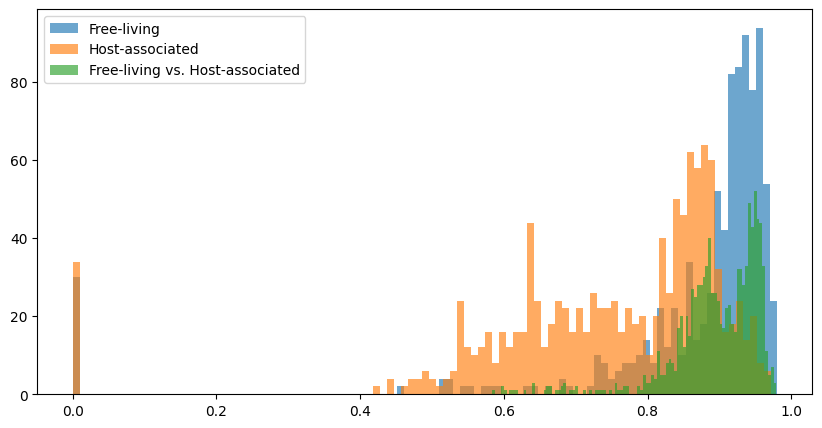

In [21]:
plt.figure(figsize=(10, 5))

empo_1 = empo_1.loc[list(full_dm.ids)]

labels = []
for env in empo_1.unique():
    env_ids = set(empo_1[empo_1 == env].index)
    within_data = full_dm.within(env_ids)
    plt.hist(within_data['value'], alpha=0.65, bins=100)
    labels.append(env)

from_label, to_label = empo_1.unique()
from_ = empo_1[empo_1 == from_label].index
to_ = empo_1[empo_1 == to_label].index

between_data = full_dm.between(from_, to_)
plt.hist(between_data['value'], alpha=0.65, bins=100)
labels.append(f'{from_label} vs. {to_label}')

plt.legend(labels);

## PCoA and PERMANOVA

Let's now move on to [Principal Coordinates Analysis](https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling) (PCoA). PCoA is a dimensionality reduction technique, which allows us to examine the primary axes of variation in a dataset. The scikit-bio implementation is based on [Legendre & Legendre](https://shop.elsevier.com/books/numerical-ecology/legendre/978-0-444-89249-2), but scikit-bio also supports an approximate version of PCoA, where the number of dimensions calculated is parameterized, and is scalable to quite large datasets.

As we'll see, the `OrdinationResults` object has a few member methods, including a `DataFrame` representation of the coordinate data.

In [22]:
from skbio.stats.ordination import pcoa

In [23]:
pc = pcoa(full_dm, number_of_dimensions=10)

In [24]:
pc.proportion_explained

,0
PC1,0.138315
PC2,0.076277
PC3,0.048983
PC4,0.043800
PC5,0.036729
PC6,0.035139
PC7,0.031202
PC8,0.028992
PC9,0.025259
PC10,0.023789


In [25]:
pc.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
13114.jensen.43.s012,-0.184117,-0.019461,0.094711,-0.191194,0.091371,-0.109596,-0.190440,0.006558,0.074419,0.114983
13114.jensen.43.s013,-0.150555,-0.033355,0.162171,-0.117278,0.065958,-0.138902,-0.151878,-0.045730,0.020265,-0.229857
13114.jensen.43.s014,-0.082994,-0.047390,0.107563,-0.291595,-0.060971,0.065959,-0.144140,-0.070948,0.290017,-0.150265
13114.pinto.63.s001,0.294731,-0.093470,-0.007113,0.011903,-0.045959,0.073883,-0.047806,-0.044864,0.053583,0.013690
13114.pinto.63.s002,0.241393,-0.133969,0.034655,0.005818,-0.029397,0.064435,-0.005094,0.026321,0.010999,-0.004113


Using the cordinates, we can make a single scatter plot of the samples

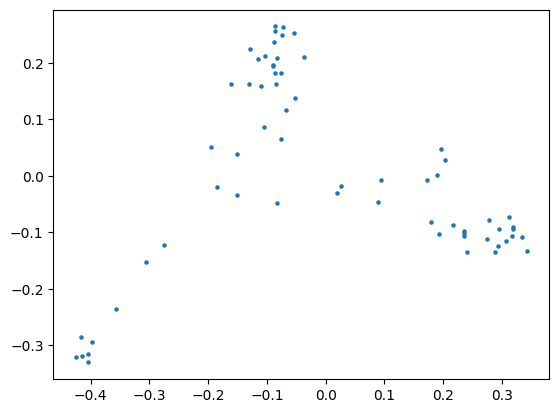

In [26]:
plt.scatter(pc.samples['PC1'], pc.samples['PC2'], s=5);

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.



In [27]:
def pcoa_plot(ord_result, sample_metadata, category, title=None):
    plt.figure(figsize=(7, 7))
    if len(ord_result.samples) > 300:
        s = 5
    else:
        s = 10

    labels = []
    ord_ids = set(ord_result.samples.index)
    category_series = sample_metadata.get_column(category).to_series()
    for env in category_series.unique():
        labels.append(env)

        env_ids = sample_metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)
        plt.scatter(ord_result.samples.loc[env_ids, 'PC1'],
                    ord_result.samples.loc[env_ids, 'PC2'],
                    s=s, alpha=0.75)
        ax = plt.gca()
        ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
        ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
        plt.legend(labels)
        if title is not None:
            plt.title(title)


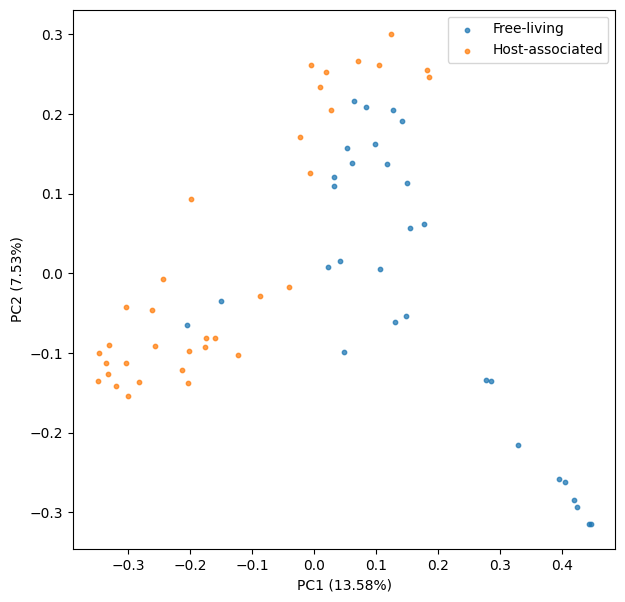

In [ ]:
pcoa_plot(pc, sample_metadata, 'empo_1')

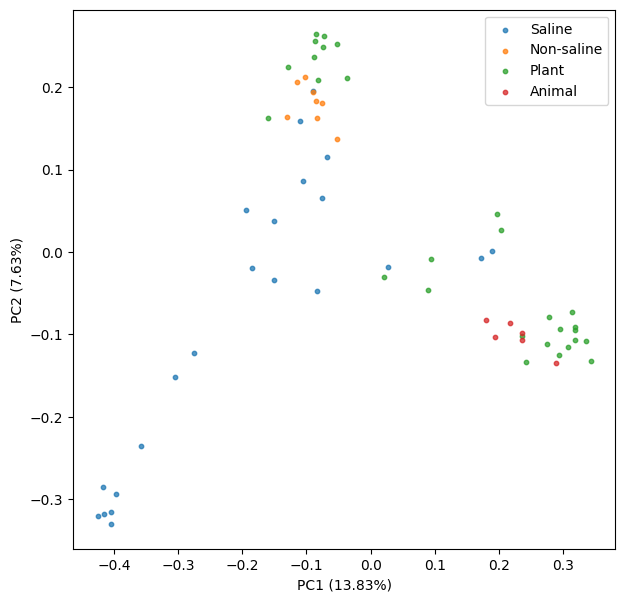

In [28]:
pcoa_plot(pc, sample_metadata, 'empo_2')

To support the above analyses, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x) to the distances. PERMANOVA is a non-parametric analysis of variance. By default, PERMANOVA computes 999 permutations which is used to estimate the p-value.

In [29]:
from skbio.stats.distance import permanova

In [30]:
permanova(full_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,64
number of groups,2
test statistic,5.58571
p-value,0.001
number of permutations,999


In [31]:
empo_2 = sample_metadata.get_column('empo_2').to_series()
permanova(full_dm, empo_2)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,64
number of groups,4
test statistic,3.802022
p-value,0.001
number of permutations,999


## Incorporating phylogeny

In [62]:
sample_metadata

SampleMetadata
--------------
92 IDs x 33 columns
sample_name_original:          ColumnProperties(type='categorical', missing_scheme='blank')
sample_type:                   ColumnProperties(type='categorical', missing_scheme='blank')
collection_timestamp:          ColumnProperties(type='categorical', missing_scheme='blank')
country:                       ColumnProperties(type='categorical', missing_scheme='blank')
depth_sample:                  ColumnProperties(type='numeric', missing_scheme='blank')
description:                   ColumnProperties(type='categorical', missing_scheme='blank')
elevation:                     ColumnProperties(type='numeric', missing_scheme='blank')
emp500_principal_investigator: ColumnProperties(type='categorical', missing_scheme='blank')
emp500_study_id:               ColumnProperties(type='numeric', missing_scheme='blank')
emp500_pi_study_id:            ColumnProperties(type='categorical', missing_scheme='blank')
emp500_title:                  ColumnPrope

In [51]:
latam_shotgun = Table.read(f'{HOME}/latam/shotgun/latam_ogu.biom')
latam_shotgun

14933 x 68 <class 'biom.table.Table'> with 90562 nonzero entries (8% dense)

In [56]:
from skbio import table

In [58]:
latamtax_path = HOME + "shotgun/latam_ogu.tax"
latam_tax = pd.read_csv(latamtax_path, sep='\t', low_memory=False, header=None,index_col=0)
latam_tax

,1
0,
G000005825,d__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...
G000006175,d__Archaea; p__Methanobacteriota_A; c__Methano...
G000006605,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
G000006725,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
G000006745,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
...,...
G902826025,d__Bacteria; p__Actinobacteriota; c__Acidimicr...
G902826465,d__Bacteria; p__Acidobacteriota; c__Vicinamiba...
G902826605,d__Bacteria; p__Acidobacteriota; c__Acidobacte...


In [32]:
sample_ids = even_table.ids()
samples_represented = {id_: set(sample_ids[v.indices])
                       for v, id_, _ in even_table.iter(axis='observation', dense=False)}


In [33]:
from functools import reduce
from operator import or_

In [34]:
for node in phylogeny.postorder():
    if node.is_tip():
        node.samples_represented = samples_represented.get(node.name, set())
        node.tips_represented = {node.name, }

    else:
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

In [35]:
for child in phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 63
Samples with N3: 64


In [37]:
from operator import itemgetter

In [38]:
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

named_nodes = sorted(named_nodes, key=itemgetter(1), reverse=True)
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

In [39]:
for child in phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 63
Samples with N3: 64


In [40]:
def intersect_with_node(tab, node):
    tips_in_table = set(tab.ids(axis='observation'))
    tipset = node.tips_represented & tips_in_table
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

In [42]:
first_name, _, first_node = named_nodes[0]
second_name, _, second_node = named_nodes[2]


even_table_first = intersect_with_node(latam_shotgun, first_node).subsample(depth)
even_table_second = intersect_with_node(latam_shotgun, second_node).subsample(depth)


IndexError: list index out of range

## Mantel test

In [43]:
from skbio.stats.distance import mantel

In [44]:
r, p, _ = mantel(first_dm, empo_1)
print(f"Mantel r={r:0.2} p={p:0.2}")

NameError: name 'first_dm' is not defined

## NMDS

In [3]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
# prompt: genera un dataframe de las distancias de full_dm con nombre de columna y renglon la muestra correspondiente

import pandas as pd
import seaborn as sns
# Generate a pandas DataFrame from the distance matrix
full_dm_df = pd.DataFrame(full_dm.data, index=full_dm.ids, columns=full_dm.ids)

# Print the first few rows of the DataFrame
print(full_dm_df.head())
nmds = MDS(n_components=2, dissimilarity='precomputed', metric=False, random_state=42)
nmds_coords = nmds.fit_transform(full_dm_df.values)

plt.scatter(nmds_coords[:, 0], nmds_coords[:, 1])
plt.title("NMDS (Unifrac)")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.grid(True)
plt.show()

# Use the filter method provided by SampleMetadata
valid_sample_names = full_dm_df.index.intersection(sample_metadata.ids()) # Ensure valid_sample_names are in sample_metadata ids
filtered_sample_metadata = sample_metadata.filter(valid_sample_names)

# Access the 'empo_1' column as a pandas Series for plotting
empo_1_series = filtered_sample_metadata.get_column('empo_1').to_series()


sns.scatterplot(x=nmds_coords[:, 0], y=nmds_coords[:, 1],
                hue=empo_1_series, palette='Set2')
plt.title("NMDS colored by empo_1") # Updated title to reflect column name
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'full_dm' is not defined

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.  

In [ ]:
def pcoa_plot(ord_result, metadata, category, title=None):
    plt.figure(figsize=(7, 7))

    # adjust the point size based on the number of samples
    if len(ord_result.samples) > 300:
        s = 5
    else:
        s = 10

    labels = []

    ord_ids = set(ord_result.samples.index)
    category_series = metadata.get_column(category).to_series()
    for env in category_series.unique():
        labels.append(env)

        env_ids = metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)

        plt.scatter(ord_result.samples.loc[env_ids, 'PC1'],
                    ord_result.samples.loc[env_ids, 'PC2'],
                    s=s, alpha=0.75)
    ax = plt.gca()
    ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
    ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
    plt.legend(labels)
    if title is not None:
        plt.title(title)

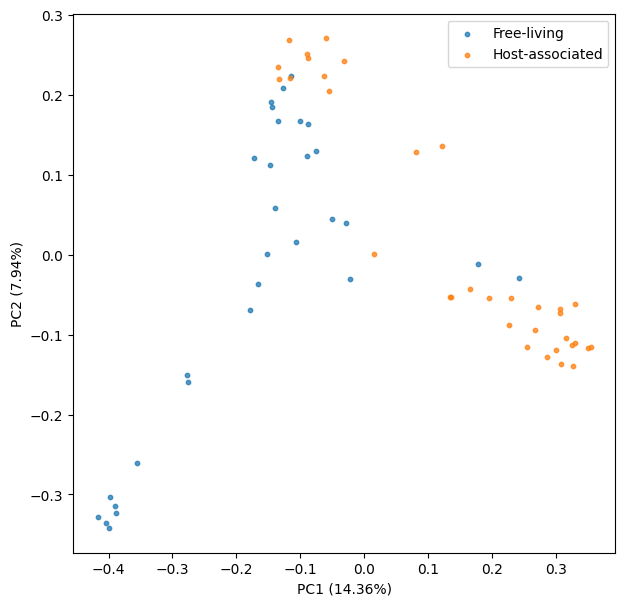

In [ ]:
pcoa_plot(pc, metadata, 'empo_1')

To support the above analyses, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x) to the distances. PERMANOVA is a non-parametric analysis of variance. By default, PERMANOVA computes 999 permutations which is used to estimate the p-value.

In [ ]:
from skbio.stats.distance import permanova

In [ ]:
permanova(full_dm, empo_1)
#pseudo F is the same thanin Anova, If F is larger than 1, then the groups are different

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,64
number of groups,2
test statistic,5.463305
p-value,0.001
number of permutations,999


## Exercise # 1 Generate a Unifrac visualization with empo_2

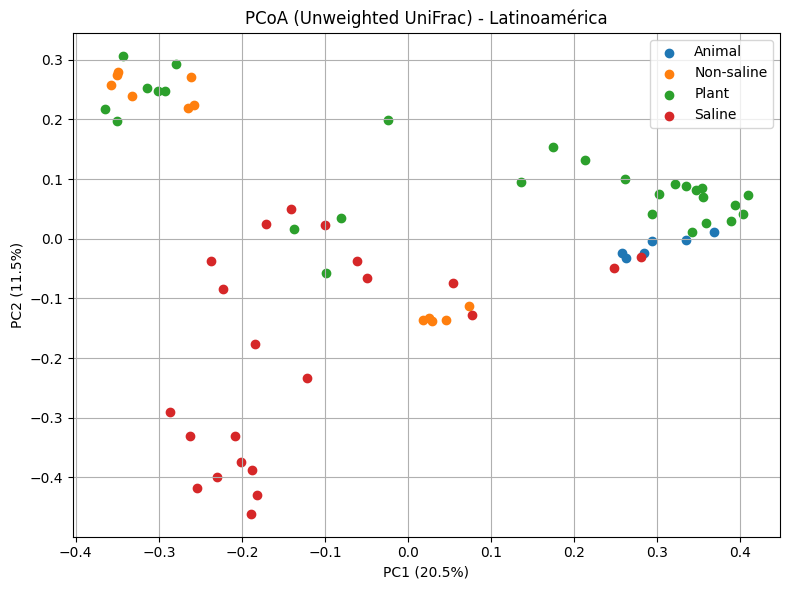

In [ ]:
# 6. Extraer matriz de datos
# Transpose the data array to have shape (number of samples, number of features)
data = tableShotgun.matrix_data.toarray().T  # Transpose the data array
sample_ids = tableShotgun.ids(axis='sample')
feature_ids = tableShotgun.ids(axis='observation') #This is the taxa argument

# 7. Calcular UniFrac (no ponderado)
unifrac_unweighted = beta_diversity(
    metric='unweighted_unifrac',
    counts=data,
    ids=sample_ids,
    tree=phylogeny,
    taxa=feature_ids #Adding the taxa argument
)

# 8. PCoA
pcoa_results = pcoa(unifrac_unweighted)
df_coords = pcoa_results.samples
df_coords['sample_id'] = df_coords.index

# 9. Unir coordenadas con metadata
merged = df_coords.join(LatamMeta_df, how='inner')

# 10. Visualizar PCoA con color
plt.figure(figsize=(8, 6))
for variable, group in merged.groupby('empo_2'):
    plt.scatter(group['PC1'], group['PC2'], label=variable)

plt.xlabel(f"PC1 ({round(pcoa_results.proportion_explained[0]*100, 1)}%)")
plt.ylabel(f"PC2 ({round(pcoa_results.proportion_explained[1]*100, 1)}%)")
plt.title("PCoA (Unweighted UniFrac) - Latinoamérica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Extra material. Incorporating phylogeny in Mantel test

###Label your phylogeny

In [ ]:
# prompt: generate the metadata path by joining github_data_path with "emp500/sample.tsv"
latamtax_path = github_data_path + "shotgun/latam_ogu.tax"
# Read the TSV file directly from the URL into a pandas DataFrame
tax_df = pd.read_csv(latamtax_path, sep='\t', low_memory=False, header=None,index_col=0)
taxonomy_dict = tax_df[1].to_dict()
tax_df.head()

,1
0,
G000005825,d__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...
G000006175,d__Archaea; p__Methanobacteriota_A; c__Methano...
G000006605,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
G000006725,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
G000006745,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


In [ ]:
# prompt: print first 5 elements on phylum_dict

from itertools import islice
for key, value in islice(taxonomy_dict.items(), 5):
    print(f'{key}: {value}')

G000005825: d__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales_H; f__Bacillaceae_D; g__Bacillus_S; s__Bacillus_S pseudofirmus
G000006175: d__Archaea; p__Methanobacteriota_A; c__Methanococci; o__Methanococcales; f__Methanococcaceae; g__Methanococcus; s__Methanococcus voltae_A
G000006605: d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Mycobacteriales; f__Mycobacteriaceae; g__Corynebacterium; s__Corynebacterium jeikeium
G000006725: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Xylella; s__Xylella fastidiosa
G000006745: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Vibrionaceae; g__Vibrio; s__Vibrio cholerae


In [ ]:
# --- Step 3: Attach taxonomy to tips ---
for tip in labeled_phylogeny.tips():
    #print(tip.name)
    if tip.name in taxonomy_dict:
        lineage = [level.strip() for level in taxonomy_dict[tip.name].split(';')]
        #print(lineage)
        tip.lineage = lineage  # store it as a custom attribute
        #print(tip.lineage)

    else:
        tip.lineage = []

NameError: name 'labeled_phylogeny' is not defined

In [ ]:
# --- Step 4: Recursively assign taxonomy to internal nodes ---
def assign_taxonomy(node):
    if node.is_tip():
        return node.lineage

    child_lineages = [assign_taxonomy(child) for child in node.children]

    # Find shared lineage prefix
    common = []
    for levels in zip(*child_lineages):
        if all(l == levels[0] for l in levels):
            common.append(levels[0])
        else:
            break

    node.lineage = common
    if common:
        node.name = common[-1]  # Assign the most specific shared level
    return common

assign_taxonomy(labeled_phylogeny)

NameError: name 'labeled_phylogeny' is not defined

In [ ]:


from io import StringIO

# Get Newick string
output = StringIO()
labeled_phylogeny.write(output, format='newick')
newick_str = output.getvalue()
print(newick_str)

NameError: name 'labeled_phylogeny' is not defined

In [ ]:
# prompt: find in tree a name that contain G000006605 but is not equal to G000006605

# Iterate through all nodes in the tree
for node in labeled_phylogeny.levelorder(include_self=True):
    # Check if the node name contains the substring and is not equal to the substring
    if 'G000315565' in node.name: #and node.name != 'G000006605':
      #phylum = taxonomy.split(";")[1].strip()
      print(node.name)


NameError: name 'labeled_phylogeny' is not defined

In [ ]:
labeled_phylogeny
print(labeled_phylogeny.find('G000315565').parent.parent.ascii_art())

NameError: name 'labeled_phylogeny' is not defined

### Incorporating phylogeny

Now, let's tinker.

We might wonder whether the sample-to-sample relationships are consistent when constrained to particular phyla.

To do this, we're going to aggregate sample information up the phylogeny (from tip to root). Specifically, we are going to determine the set of samples a feature is present in, and then push the unique sample IDs up the tree through a postorder traversal, effecively reducing the information.

While doing so, we are also going to cache the names of the features found within a clade simply to facilitate filtering later on.



In [ ]:
latamtree_path = github_data_path + "latam/shotgun/latam_ogu.nwk"
labeled_phylogeny = skbio.TreeNode.read(latamtree_path, format='newick')
labeled_phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

Postorder means children are assured to be evaluted before parents. The TreeNode supports many types of traversals, and pleasant examples of common traversals can be found on [Wikipedia](https://en.wikipedia.org/wiki/Tree_traversal). Here, we will decorate these new attributes onto the tree.

The algorithm is:
1. if the object being evaluated is a tip
* get the samples represented (or the empty set)
* construct a set composed of only the feature name
2. else the object must be an internal node
* compute the set union of samples represented
* compute the set union of features represented

In [ ]:
from functools import reduce
from operator import or_

In [ ]:
sample_ids = even_table.ids()

# this complex dict comprehension maps a feature ID to the set of
# samples that feature was found it. The v.indices attribute is the
# index positions of the nonzero values within a SciPy sparse vector
samples_represented = {id_: set(sample_ids[v.indices])
                       for v, id_, _ in even_table.iter(axis='observation', dense=False)}

In [ ]:
for node in labeled_phylogeny.postorder():
    if node.is_tip():
        node.samples_represented = samples_represented.get(node.name, set())
        node.tips_represented = {node.name, }
    else:
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

Let's spot check what the representation is at the domain level.

In [ ]:
for child in labeled_phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 63
Samples with N3: 64


Next, let's gather all phylum level named nodes (p__), sort them by how many samples are represented, and print the top few

In [ ]:
from operator import itemgetter

In [ ]:
for n in labeled_phylogeny.traverse():
  if n.name is not None and n.name.startswith('p__'):
    print(n.name)

In [ ]:
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in labeled_phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

named_nodes = sorted(named_nodes, key=itemgetter(1), reverse=True)
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

In [ ]:
named_nodes

NameError: name 'named_nodes' is not defined

In [ ]:
# A helper function to intersect a table with the features represented by a node

def intersect_with_node(tab, node):
    tips_in_table = set(tab.ids(axis='observation'))
    tipset = node.tips_represented & tips_in_table
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

Now we will take two interesting sets. While testing this notebook, it was noted the number of sample IDs in common between Proteobacteria and Firmicutes_D, after rarefaction, was relatively low. So instead, let's look at Proteobacteria and Bacteroidota.

The next few cells filter the feature table to each phyla of focus, constrain them to the exact same set of IDs, compute UniFrac again, and then principal coordinates.

In [ ]:
first_name, _, first_node = named_nodes[0]
second_name, _, second_node = named_nodes[2]



NameError: name 'named_nodes' is not defined

In [ ]:
even_table_first = intersect_with_node(tableShotgun, first_node).subsample(depth)
even_table_second = intersect_with_node(tableShotgun, second_node).subsample(depth)

NameError: name 'intersect_with_node' is not defined

In [ ]:
common_ids = set(even_table_first.ids()) & set(even_table_second.ids())
even_table_first = even_table_first.filter(common_ids).remove_empty()
even_table_second = even_table_second.filter(common_ids).remove_empty()

NameError: name 'even_table_first' is not defined

In [ ]:
first_dm = beta_diversity('unweighted_unifrac', even_table_first, tree=phylogeny)
second_dm = beta_diversity('unweighted_unifrac', even_table_second, tree=phylogeny)

NameError: name 'even_table_first' is not defined

In [ ]:
first_pc = pcoa(first_dm, number_of_dimensions=10)
second_pc = pcoa(second_dm, number_of_dimensions=10)

NameError: name 'first_dm' is not defined

Now we can visualize these clade specific beta diversity calculations!

In [ ]:
pcoa_plot(first_pc, metadata, 'empo_1', first_name)

NameError: name 'first_pc' is not defined

In [ ]:
pcoa_plot(second_pc, metadata, 'empo_1', second_name)

NameError: name 'second_pc' is not defined

### Mantel test

We additionally can compute the correlation of the sample-sample relationships in both phyla using a [Mantel](https://pubmed.ncbi.nlm.nih.gov/6018555/) test. Mantel, like PERMANOVA, is non-parametric and by default uses 999 repetitions to estimate a p-value.

In the next few cells, we will compare Proteobacteria to Bacteroidota, Proteobacteria to the full tree, and Bacteroidota to the full tree. We then will apply PERMANOVA to these clade specific distance matrices.

Interestingly, we observe a relatively low correlation between these two phyla, and it seems the sample-sample relationships within Bacteroidota better recapitulate the full distance matrix. This observation is further supported by the relative difference in test statistics from PERMANOVA, where the statistic is larger between host and non-host samples.

In [ ]:
from skbio.stats.distance import mantel

In [ ]:
r, p, _ = mantel(first_dm, second_dm)
print(f"Mantel r={r:0.2} p={p:0.2}")

NameError: name 'first_dm' is not defined

In [ ]:
r, p, _ = mantel(full_dm, first_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.75 p=0.001


In [ ]:
r, p, _ = mantel(full_dm, second_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.77 p=0.001


In [ ]:
permanova(first_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,8.822204
p-value,0.001
number of permutations,999


In [ ]:
permanova(second_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,7.960979
p-value,0.001
number of permutations,999


### Proscrustes disparity

And last, we will compute the [Procrustes disparity](https://en.wikipedia.org/wiki/Procrustes_analysis), a measure of fit, between the clade specific ordinations.

Procrustes can also be permuted to estimate a p-value, however that is not directly supported at this time within scikit-bio. The procedure is relatively simple though: iterate N times, randomly shuffle the IDs of one of the matrices, recomptue Procrustes. This too is slated for inclusion directly in scikit-bio. And last, the EMPeror library (noted above) can plot Procrustes transforms linking the samples in both ordinations visually.

In [ ]:
from scipy.spatial import procrustes

In [ ]:
mtx1, mtx2, disparity = procrustes(
    first_pc.samples[['PC1', 'PC2']],
    second_pc.samples[['PC1', 'PC2']]
)
print(disparity)